In [1]:
!pip install --quiet rdkit chembl_webresource_client tqdm catboost


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Импорт библиотек


In [2]:
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from catboost import CatBoostRegressor

In [3]:
new_client

In [4]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [5]:
type(targets_api)


chembl_webresource_client.query_set.QuerySet

### Найдите мишень IRAK4 в базе ChEMBL и получите список соединений, взаимодействующих с ней.

In [6]:
target = new_client.target
gene_name = 'IRAK4'
targets = target.filter(target_synonym__icontains=gene_name).only(
    ['organism', 'pref_name', 'target_type', 'target_chembl_id'])
for i in targets:
    print(i)

print(targets)
chembl_id = targets[0]['target_chembl_id']

{'organism': 'Homo sapiens', 'pref_name': 'Interleukin-1 receptor-associated kinase 4', 'target_chembl_id': 'CHEMBL3778', 'target_type': 'SINGLE PROTEIN'}
{'organism': 'Rattus norvegicus', 'pref_name': 'Interleukin-1 receptor-associated kinase 4', 'target_chembl_id': 'CHEMBL4105995', 'target_type': 'SINGLE PROTEIN'}
{'organism': 'Homo sapiens', 'pref_name': 'Protein cereblon/IRAK4', 'target_chembl_id': 'CHEMBL4523710', 'target_type': 'PROTEIN-PROTEIN INTERACTION'}
{'organism': 'Homo sapiens', 'pref_name': 'E3 ubiquitin-protein ligase XIAP/IRAK4', 'target_chembl_id': 'CHEMBL4523723', 'target_type': 'PROTEIN-PROTEIN INTERACTION'}
{'organism': 'Homo sapiens', 'pref_name': 'VHL/IRAK4', 'target_chembl_id': 'CHEMBL4523742', 'target_type': 'PROTEIN-PROTEIN INTERACTION'}
{'organism': 'Mus musculus', 'pref_name': 'Interleukin-1 receptor-associated kinase 4', 'target_chembl_id': 'CHEMBL4630844', 'target_type': 'SINGLE PROTEIN'}
[{'organism': 'Homo sapiens', 'pref_name': 'Interleukin-1 receptor-a

In [7]:
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL3778


In [8]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "molecular_weight",
    "target_chembl_id",
    "target_organism",
    "molecule_properties__mw_freebase",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 2472, <class 'chembl_webresource_client.query_set.QuerySet'>


In [9]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
print(bioactivities[0])

Length and type of first element: 13, <class 'dict'>
{'activity_id': 1724376, 'assay_chembl_id': 'CHEMBL870864', 'assay_description': 'Inhibition of IRAK4', 'assay_type': 'B', 'molecule_chembl_id': 'CHEMBL210658', 'relation': '=', 'standard_units': 'nM', 'standard_value': '4000.0', 'target_chembl_id': 'CHEMBL3778', 'target_organism': 'Homo sapiens', 'type': 'IC50', 'units': 'uM', 'value': '4.0'}


Note that the first two rows describe the same bioactivity entry; we will remove such artifacts later during the deduplication step. Note also that we have columns for standard_units/units and standard_values/values; in the following, we will use the standardized columns (standardization by ChEMBL), and thus, we drop the other two columns.

If we used the units and values columns, we would need to convert all values with many different units to nM:



### Соберите данные о каждом соединении (ChEMBL ID, SMILES, IC50, Молекулярный вес)

In [10]:
bioactivities_all = bioactivities.all()
bioactivities_df = pd.DataFrame.from_dict(bioactivities_all)

In [11]:
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (2472, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,1724376,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL210658,=,nM,4000.0,CHEMBL3778,Homo sapiens,IC50,uM,4.0
1,1724380,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL426133,=,nM,13600.0,CHEMBL3778,Homo sapiens,IC50,uM,13.6
2,1724382,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209118,=,nM,6500.0,CHEMBL3778,Homo sapiens,IC50,uM,6.5
3,1724383,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209715,=,nM,12000.0,CHEMBL3778,Homo sapiens,IC50,uM,12.0
4,1724384,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209716,=,nM,2000.0,CHEMBL3778,Homo sapiens,IC50,uM,2.0


очистка данных

In [12]:
bioactivities_df["units"].unique()


array(['uM', 'nM', "10'-9M", '10^-9M'], dtype=object)

In [13]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,1724376,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL210658,=,nM,4000.0,CHEMBL3778,Homo sapiens,IC50
1,1724380,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL426133,=,nM,13600.0,CHEMBL3778,Homo sapiens,IC50
2,1724382,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209118,=,nM,6500.0,CHEMBL3778,Homo sapiens,IC50
3,1724383,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209715,=,nM,12000.0,CHEMBL3778,Homo sapiens,IC50
4,1724384,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209716,=,nM,2000.0,CHEMBL3778,Homo sapiens,IC50


Очистка Датафрейма:
Удаление NaN

In [14]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")


DataFrame shape: (2472, 11)


Только “standard_unit == *nM”*

In [15]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}")

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [16]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [17]:
bioactivities_df

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,1724376,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL210658,=,nM,4000.0,CHEMBL3778,Homo sapiens,IC50
1,1724380,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL426133,=,nM,13600.0,CHEMBL3778,Homo sapiens,IC50
2,1724382,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209118,=,nM,6500.0,CHEMBL3778,Homo sapiens,IC50
3,1724383,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209715,=,nM,12000.0,CHEMBL3778,Homo sapiens,IC50
4,1724384,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209716,=,nM,2000.0,CHEMBL3778,Homo sapiens,IC50
...,...,...,...,...,...,...,...,...,...,...,...
2467,25732260,CHEMBL5393417,Inhibition of recombinant human full length hi...,B,CHEMBL5421046,=,nM,0.4,CHEMBL3778,Homo sapiens,IC50
2468,25732261,CHEMBL5393417,Inhibition of recombinant human full length hi...,B,CHEMBL5408807,=,nM,0.5,CHEMBL3778,Homo sapiens,IC50
2469,25732262,CHEMBL5393417,Inhibition of recombinant human full length hi...,B,CHEMBL5412221,=,nM,0.5,CHEMBL3778,Homo sapiens,IC50
2470,25755807,CHEMBL5446112,Affinity Biochemical interaction: (Dissociatio...,B,CHEMBL4081711,=,nM,0.2,CHEMBL3778,Homo sapiens,IC50


Удаление дублей

In [18]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2026, 11)


Индексация

In [19]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,1724376,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL210658,=,nM,4000.0,CHEMBL3778,Homo sapiens,IC50
1,1724380,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL426133,=,nM,13600.0,CHEMBL3778,Homo sapiens,IC50
2,1724382,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209118,=,nM,6500.0,CHEMBL3778,Homo sapiens,IC50
3,1724383,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209715,=,nM,12000.0,CHEMBL3778,Homo sapiens,IC50
4,1724384,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209716,=,nM,2000.0,CHEMBL3778,Homo sapiens,IC50


In [20]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

compounds = list(compounds_provider[:5000])  # Без tqdm

In [21]:
compounds_df = pd.DataFrame.from_dict(compounds)
compounds_df

,molecule_chembl_id,molecule_structures
0,CHEMBL288441,{'canonical_smiles': 'COc1cc(Nc2c(C#N)cnc3cc(O...
1,CHEMBL206991,{'canonical_smiles': 'COc1ccc2[nH]c(NC(=O)c3cc...
2,CHEMBL208561,{'canonical_smiles': 'COC(=O)c1ccc2[nH]c(NC(=O...
3,CHEMBL209820,{'canonical_smiles': 'CCCS(=O)(=O)c1ccc2[nH]c(...
4,CHEMBL208709,{'canonical_smiles': 'CCOC(=O)CCn1c(NC(=O)c2cc...
...,...,...
2021,CHEMBL5437103,{'canonical_smiles': 'CC(=O)Nc1cc(-c2nc(C(=O)N...
2022,CHEMBL5438284,{'canonical_smiles': 'COc1ccc(-c2cc3c(cc2NC(=O...
2023,CHEMBL5438469,{'canonical_smiles': 'CC(C)n1cc(-c2cc3c(cc2NC(...
2024,CHEMBL5439081,{'canonical_smiles': 'COc1cc2nc(C3CCCS(=O)(=O)...


In [22]:

print(f"DataFrame shape: {compounds_df.shape}")

canonical_smiles = []

for i, compounds in compounds_df.iterrows():
  try:
    canonical_smiles.append(compounds['molecule_structures']["canonical_smiles"])
  except:
    canonical_smiles.append(None)


compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2026, 2)
DataFrame shape: (2026, 2)


In [23]:
canonical_smiles

['COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc23)c(Cl)cc1Cl',
 'COc1ccc2[nH]c(NC(=O)c3cccc([N+](=O)[O-])c3)nc2c1',
 'COC(=O)c1ccc2[nH]c(NC(=O)c3cccc([N+](=O)[O-])c3)nc2c1',
 'CCCS(=O)(=O)c1ccc2[nH]c(NC(=O)c3cccc([N+](=O)[O-])c3)nc2c1',
 'CCOC(=O)CCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21',
 'O=C(Nc1nc2ccccc2n1C1CCOC1=O)c1cccc([N+](=O)[O-])c1',
 'C=CCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21',
 'CCCCCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21',
 'O=C(Nc1nc2ccccc2[nH]1)c1cccc([N+](=O)[O-])c1',
 'O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1',
 'O=C(Nc1nc2cc(Cl)ccc2[nH]1)c1cccc([N+](=O)[O-])c1',
 'O=C(Nc1nc2cc(F)ccc2[nH]1)c1cccc([N+](=O)[O-])c1',
 'Cc1ccc2[nH]c(NC(=O)c3cccc([N+](=O)[O-])c3)nc2c1',
 'O=C(Nc1nc2ccccc2n1CCC1CCC1)c1cccc([N+](=O)[O-])c1',
 'COCCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21',
 'CCOCCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21',
 'CCOC(=O)Cn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21',
 'O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-])c1',
 'O=C(Nc1nc2ccccc

In [24]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2026, 2)
DataFrame shape: (2026, 2)


In [25]:
compounds_df


,molecule_chembl_id,smiles
0,CHEMBL288441,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...
1,CHEMBL206991,COc1ccc2[nH]c(NC(=O)c3cccc([N+](=O)[O-])c3)nc2c1
2,CHEMBL208561,COC(=O)c1ccc2[nH]c(NC(=O)c3cccc([N+](=O)[O-])c...
3,CHEMBL209820,CCCS(=O)(=O)c1ccc2[nH]c(NC(=O)c3cccc([N+](=O)[...
4,CHEMBL208709,CCOC(=O)CCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2...
...,...,...
2021,CHEMBL5437103,CC(=O)Nc1cc(-c2nc(C(=O)Nc3cc4c(cc3N3CCC(CO)CC3...
2022,CHEMBL5438284,COc1ccc(-c2cc3c(cc2NC(=O)c2coc(-c4ccnc(N)c4)n2...
2023,CHEMBL5438469,CC(C)n1cc(-c2cc3c(cc2NC(=O)c2coc(-c4ccnc(N)c4)...
2024,CHEMBL5439081,COc1cc2nc(C3CCCS(=O)(=O)C3)n(C)c2cc1NC(=O)c1cc...


Объединение двух датасетов

In [26]:
bioactivities_df

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,1724376,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL210658,=,nM,4000.0,CHEMBL3778,Homo sapiens,IC50
1,1724380,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL426133,=,nM,13600.0,CHEMBL3778,Homo sapiens,IC50
2,1724382,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209118,=,nM,6500.0,CHEMBL3778,Homo sapiens,IC50
3,1724383,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209715,=,nM,12000.0,CHEMBL3778,Homo sapiens,IC50
4,1724384,CHEMBL870864,Inhibition of IRAK4,B,CHEMBL209716,=,nM,2000.0,CHEMBL3778,Homo sapiens,IC50
...,...,...,...,...,...,...,...,...,...,...,...
2021,25732259,CHEMBL5393417,Inhibition of recombinant human full length hi...,B,CHEMBL5410702,=,nM,0.3,CHEMBL3778,Homo sapiens,IC50
2022,25732260,CHEMBL5393417,Inhibition of recombinant human full length hi...,B,CHEMBL5421046,=,nM,0.4,CHEMBL3778,Homo sapiens,IC50
2023,25732261,CHEMBL5393417,Inhibition of recombinant human full length hi...,B,CHEMBL5408807,=,nM,0.5,CHEMBL3778,Homo sapiens,IC50
2024,25732262,CHEMBL5393417,Inhibition of recombinant human full length hi...,B,CHEMBL5412221,=,nM,0.5,CHEMBL3778,Homo sapiens,IC50


In [27]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "standard_value", "standard_units", 'type']],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 2026 entries.


In [28]:
output_df

,molecule_chembl_id,standard_value,standard_units,type,smiles
0,CHEMBL210658,4000.0,nM,IC50,O=C(Nc1nc2ccccc2[nH]1)c1cccc([N+](=O)[O-])c1
1,CHEMBL426133,13600.0,nM,IC50,N#Cc1cccc(C(=O)Nc2nc3ccccc3[nH]2)c1
2,CHEMBL209118,6500.0,nM,IC50,O=C(Nc1nc2ccccc2[nH]1)c1ccc(F)c([N+](=O)[O-])c1
3,CHEMBL209715,12000.0,nM,IC50,Cc1ccc(C(=O)Nc2nc3ccccc3[nH]2)cc1[N+](=O)[O-]
4,CHEMBL209716,2000.0,nM,IC50,CCCCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21
...,...,...,...,...,...
2021,CHEMBL5410702,0.3,nM,IC50,COc1cc2nn([C@H]3CC[C@H](N(C)C(=O)[C@@H](C)O)CC...
2022,CHEMBL5421046,0.4,nM,IC50,COc1cc2nn([C@H]3CC[C@]4(CC3)COC(=O)N4C)cc2cc1C...
2023,CHEMBL5408807,0.5,nM,IC50,COc1cc2nn([C@H]3CC[C@H](n4ccccc4=O)CC3)cc2cc1C...
2024,CHEMBL5412221,0.5,nM,IC50,COc1cc2nn([C@H]3CC[C@H](n4ccnc4C(C)O)CC3)cc2cc...


In [29]:
output_df.dropna(axis=0, how="any", inplace=True)

In [30]:
output_df

,molecule_chembl_id,standard_value,standard_units,type,smiles
0,CHEMBL210658,4000.0,nM,IC50,O=C(Nc1nc2ccccc2[nH]1)c1cccc([N+](=O)[O-])c1
1,CHEMBL426133,13600.0,nM,IC50,N#Cc1cccc(C(=O)Nc2nc3ccccc3[nH]2)c1
2,CHEMBL209118,6500.0,nM,IC50,O=C(Nc1nc2ccccc2[nH]1)c1ccc(F)c([N+](=O)[O-])c1
3,CHEMBL209715,12000.0,nM,IC50,Cc1ccc(C(=O)Nc2nc3ccccc3[nH]2)cc1[N+](=O)[O-]
4,CHEMBL209716,2000.0,nM,IC50,CCCCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21
...,...,...,...,...,...
2021,CHEMBL5410702,0.3,nM,IC50,COc1cc2nn([C@H]3CC[C@H](N(C)C(=O)[C@@H](C)O)CC...
2022,CHEMBL5421046,0.4,nM,IC50,COc1cc2nn([C@H]3CC[C@]4(CC3)COC(=O)N4C)cc2cc1C...
2023,CHEMBL5408807,0.5,nM,IC50,COc1cc2nn([C@H]3CC[C@H](n4ccccc4=O)CC3)cc2cc1C...
2024,CHEMBL5412221,0.5,nM,IC50,COc1cc2nn([C@H]3CC[C@H](n4ccnc4C(C)O)CC3)cc2cc...


In [31]:
# Убеждаемся, что standard_value — числовой столбец
output_df['standard_value'] = pd.to_numeric(
    output_df['standard_value'], errors='coerce')

# Фильтруем: оставляем только положительные значения
output_df = output_df[output_df['standard_value'] > 0]

# Выводим финальный результат
print(f"Осталось строк после фильтрации: {output_df.shape[0]}")
output_df.head()

Осталось строк после фильтрации: 2025


,molecule_chembl_id,standard_value,standard_units,type,smiles
0,CHEMBL210658,4000.0,nM,IC50,O=C(Nc1nc2ccccc2[nH]1)c1cccc([N+](=O)[O-])c1
1,CHEMBL426133,13600.0,nM,IC50,N#Cc1cccc(C(=O)Nc2nc3ccccc3[nH]2)c1
2,CHEMBL209118,6500.0,nM,IC50,O=C(Nc1nc2ccccc2[nH]1)c1ccc(F)c([N+](=O)[O-])c1
3,CHEMBL209715,12000.0,nM,IC50,Cc1ccc(C(=O)Nc2nc3ccccc3[nH]2)cc1[N+](=O)[O-]
4,CHEMBL209716,2000.0,nM,IC50,CCCCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21


####    Найдено 2025 соединений

### Добавляем молекулярный вес

In [32]:
# Создаем копию DataFrame, чтобы избежать предупреждения
output_df = output_df.copy()

# Добавим колонку для молекулярного веса
output_df['molecular_weight'] = None

# Функция для расчета молекулярного веса


def calculate_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolWt(mol)
    return None


# Добавляем молекулярный вес в DataFrame
for index, row in output_df.iterrows():
    smiles = row['smiles']  # Получаем SMILES из колонки 'smiles'
    if smiles:  # Проверяем, что SMILES не пустой
        mw = calculate_molecular_weight(smiles)
        output_df.at[index, 'molecular_weight'] = mw

# Выводим обновленный DataFrame
print(output_df.head())

  molecule_chembl_id  standard_value standard_units  type  \
0       CHEMBL210658          4000.0             nM  IC50   
1       CHEMBL426133         13600.0             nM  IC50   
2       CHEMBL209118          6500.0             nM  IC50   
3       CHEMBL209715         12000.0             nM  IC50   
4       CHEMBL209716          2000.0             nM  IC50   

                                            smiles molecular_weight  
0     O=C(Nc1nc2ccccc2[nH]1)c1cccc([N+](=O)[O-])c1          282.259  
1              N#Cc1cccc(C(=O)Nc2nc3ccccc3[nH]2)c1          262.272  
2  O=C(Nc1nc2ccccc2[nH]1)c1ccc(F)c([N+](=O)[O-])c1          300.249  
3    Cc1ccc(C(=O)Nc2nc3ccccc3[nH]2)cc1[N+](=O)[O-]          296.286  
4  CCCCn1c(NC(=O)c2cccc([N+](=O)[O-])c2)nc2ccccc21          338.367  


### Постройте таблицу, которая включает топ-10 соединений по IC50.

In [33]:
# Сортируем по standard_value (IC50) по убыванию
df_sorted = output_df.sort_values(by='standard_value', ascending=False)

# Выбираем топ-10 соединений
top_10 = df_sorted.head(10)

# Выводим результат
print(top_10)

     molecule_chembl_id  standard_value standard_units  type  \
169       CHEMBL3403451       3012000.0             nM  IC50   
165       CHEMBL3403447       1193000.0             nM  IC50   
170       CHEMBL3403452       1081000.0             nM  IC50   
2016      CHEMBL5439182        426000.0             nM  IC50   
168       CHEMBL3403450        403000.0             nM  IC50   
167       CHEMBL3403449        333000.0             nM  IC50   
166       CHEMBL3403448        228000.0             nM  IC50   
1427      CHEMBL4093989         55000.0             nM  IC50   
2018      CHEMBL5395784         43000.0             nM  IC50   
171       CHEMBL3403453         42000.0             nM  IC50   

                                                 smiles molecular_weight  
169   OC[C@H]1C[C@@H](Nc2nc(NC3CCCCC3)ncc2-c2nc3cccc...          455.584  
165   CCCNc1ncc(-c2nc3ccccc3s2)c(N[C@@H]2C[C@H](CO)[...          415.519  
170   OC[C@H]1C[C@@H](Nc2nc(NC3CCOCC3)ncc2-c2nc3cccc...          457.5

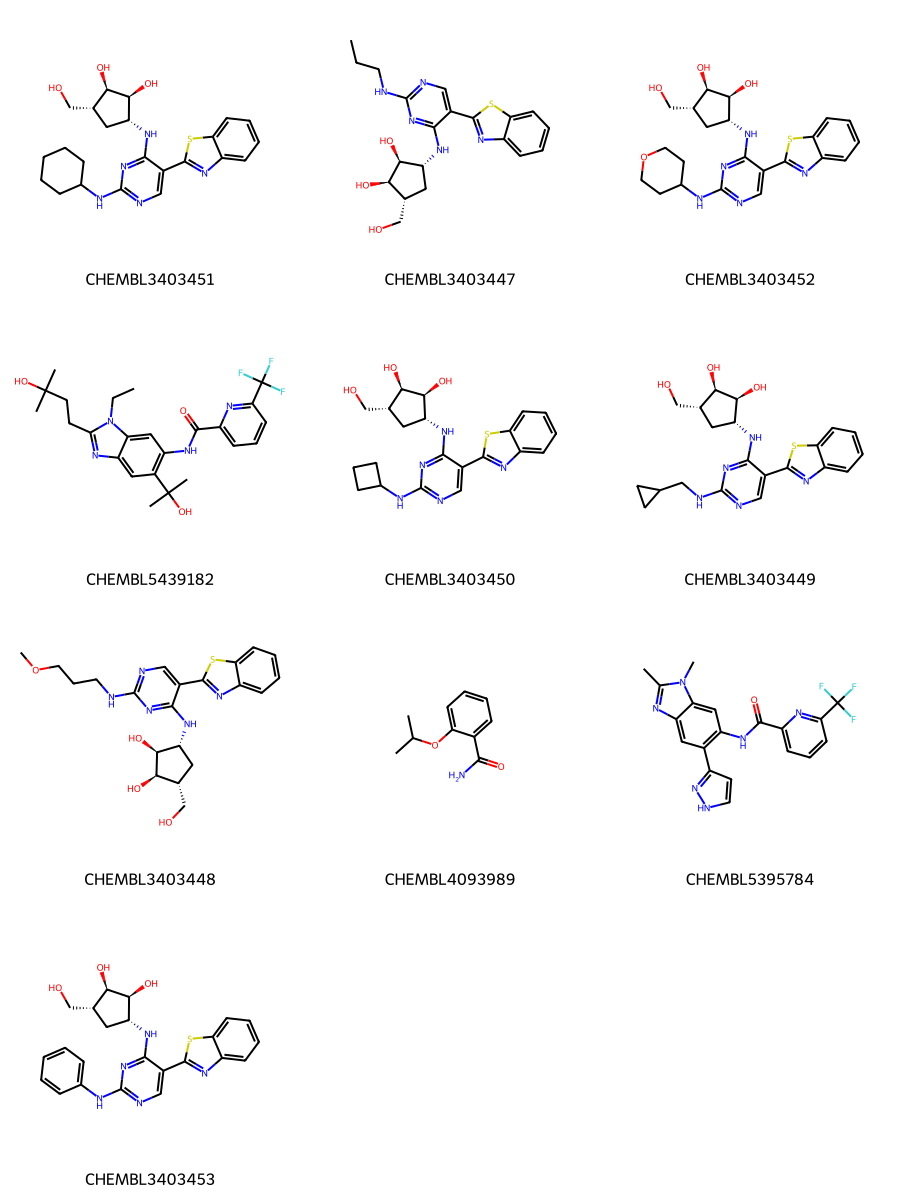

In [34]:
# Извлекаем SMILES из колонки 'smiles'
smiles_list = top_10['smiles'].tolist()

# Извлекаем molecule_chembl_id для подписей
legends_list = top_10['molecule_chembl_id'].tolist()

# Преобразуем SMILES в молекулы (объекты RDKit)
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Визуализация молекул
img = Draw.MolsToGridImage(
    molecules,
    molsPerRow=3,  # Количество молекул в строке
    subImgSize=(300, 300),  # Размер изображения для каждой молекулы
    legends=legends_list  # Используем molecule_chembl_id в качестве подписей
)

# Отображение молекул
img

### Построение модели

Morgan Fingerprints


In [35]:
def calculate_morgan_fingerprints(smiles, radius=3, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        generator = GetMorganGenerator(radius=radius, fpSize=n_bits)
        return generator.GetFingerprint(mol)
    else:
        return None

In [36]:
output_df.loc[:, 'fingerprints'] = output_df['smiles'].apply(
    calculate_morgan_fingerprints)

In [37]:
X = pd.DataFrame([list(fp) for fp in output_df['fingerprints']])
print(X)


      0     1     2     3     4     5     6     7     8     9     ...  2038  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
2020     0     1     0     0     0     0     0     0     0     0  ...     0   
2021     0     0     0     0     0     0     0     0     0     0  ...     0   
2022     0     0     0     0     0     0     0     0     0     0  ...     0   
2023     0     1     0     0     0     0     0     0     0     0  ...     0   
2024     0     1     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

In [38]:
y = -np.log(output_df['standard_value'])+9

In [39]:
y

0        0.705950
1       -0.517825
2        0.220443
3       -0.392662
4        1.399098
          ...    
2021    10.203973
2022     9.916291
2023     9.693147
2024     9.693147
2025     0.588167
Name: standard_value, Length: 2025, dtype: float64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the CatBoost model
model = CatBoostRegressor(iterations=10000, verbose=0)
model.fit(X_train, y_train)

In [41]:
predictions = model.predict(X_test)
print(X_test)

      0     1     2     3     4     5     6     7     8     9     ...  2038  \
1970     0     0     0     0     0     0     0     0     0     0  ...     0   
1726     0     0     0     0     0     0     0     0     0     0  ...     0   
527      0     1     0     0     0     0     0     0     0     1  ...     1   
994      0     0     0     0     0     0     0     0     0     0  ...     0   
1124     0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1673     0     1     0     0     0     0     0     0     1     0  ...     0   
637      0     1     0     0     0     0     0     0     0     0  ...     0   
1456     0     0     0     0     0     0     0     0     0     1  ...     0   
1549     0     0     0     0     0     0     0     0     0     1  ...     0   
1835     0     0     0     0     0     0     0     0     0     0  ...     0   

      2039  2040  2041  2042  2043  2044  2045  204

Метрика Mean Absoulte Error

In [42]:
mean_absolute_error(predictions, y_test)

1.0402947367210278

In [43]:
r2_score(predictions, y_test)

0.5385780568093668